# Labeling Disaster-Related Messages

### Business Case
During emergencies, responders and law enforcement need to act quickly and respond appropriately. Handling language (text) data from news sources, direct messages, voice-to-text, and social media posts can mean the difference between saving a life and missing something important.

In this situation, thousands of messages per minute need to be interpreted and categorized in order to find messages that are requesting aid from the responders.

If successful, the emergency responders will be able to quickly and accurately identify messages requesting aid in order to streamline resources and make a positive difference in the situation.

### Problem
Given text data of disaster-related messages and news bulletins (English / English translation), can we correctly assign labels to the message?

<img src='./images/wordcloud.png'>

> The task will involve **Natural Language Processing** (*NLP*) analysis.

https://appen.com/datasets/combined-disaster-response-data/

**Final Project Submission**

* **Student name:** Claude Fried
* **Student pace:** Part-time
* **Scheduled project review date/time:** Dec 10, 2020
* **Instructor name:** James Irving
* **Blog post URL:** https://cwf231.github.io/deepmind_-_leading_the_way_with_artificial_neural_networks


### Objective
Our goal is to create a model that can interpret and label a message using **Natural Language Processing**. A message can have up to 37 labels (for example if the message is requesting medical help or offering aid).

In order to simplify the given dataset, I will be working only with a single label: `aid-related`.

> **Question:** Can we create a model that can correctly label a message as being **aid-related** using only the message itself?

### Success Criteria
We will be using `recall_score`, `precision_score`, `f1-score`, and `accuracy_score` to assess our models.
***
#### Metrics & Loss
##### Recall Score
The recall score of a prediction is the ratio of **correct true positives** to **total positive samples**. *Recall only considers the correctness of samples that are actually `true`.*
> $\LARGE {Recall} = \frac{TP}{TP + FN}$

```python
>>> y_true = np.array([0, 0, 1, 1])
>>> y_pred = np.array([1, 1, 0, 1])
>>> 
>>> # 1/2 (0.5) true positives correctly labeled.
>>> recall_score(y_true, y_pred)
0.5
```
***
##### Precision Score
The precision score of a prediction is the ratio of **correct positive predictions** to **total positive predictions.** *Precision only considers samples where the prediction is `true`.*
> $\LARGE {Precision} = \frac{TP}{TP + FP}$

```python
>>> y_true = np.array([0, 0, 1, 1])
>>> y_pred = np.array([1, 1, 0, 1])
>>> 
>>> # 1/3 (0.33) predicted positives are correctly labeled.
>>> precision_score(y_true, y_pred)
0.3333333333333333
```
***
##### F1-Score
> *Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.*
>
> *The F-measure (and measures) can be interpreted as a weighted harmonic mean of the precision and recall.*
> https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics
> 
> $\LARGE {f_1} = 2 \times \frac{precision \times recall}{precision + recall}$


```python
>>> y_true = np.array([0, 0, 1, 1])
>>> y_pred = np.array([1, 1, 0, 1])
>>> 
>>> # 2 * ((0.333 * 0.5) / (0.333 + 0.5)) = 0.3999759990399616
>>> f1_score(y_true, y_pred)
0.4
```
***
##### Accuracy Score
The accuracy of a prediction is the ratio of **correct labels** to **total labels**. *The accuracy takes into account all of the models predictions, but can be misleading with imbalanced label distributions.*
> 
> $\LARGE {accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

```python
>>> y_true = np.array([0, 0, 1, 1])
>>> y_pred = np.array([1, 1, 0, 1])
>>> 
>>> # 1/4 (0.25) correctly labeled predictions.
>>> accuracy_score(y_true, y_pred)
0.25
```
***
##### Binary Cross-Entropy
Binary Cross-Entropy (*log-loss*) measures the loss based on how wrong the model's predictions are.

Unlike other metrics used, Binary Cross-Entropy is able to measure continuous entries rather than just binary.

$\LARGE {cross entropy} = -\sum_{c=1}^My_{o,c}\log(p_{o,c})$

> *Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.*
>
> *https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html*

```python
>>> # For samples guessed relatively close to the actual values, the log loss will be low.
>>> y_true = np.array([0.  , 0.  , 1.  , 1.  ])
>>> y_pred = np.array([0.15, 0.15, 0.9 , 1.  ])
>>> 
>>> binary_crossentropy(y_true, y_pred).numpy()
0.1075995070620419

>>> # However, bad predictions will have a large effect on the loss.
>>> y_true = np.array([0.  , 0.  , 1.  , 1.  ])
>>> y_pred = np.array([0.85, 0.15, 0.9 , 1.  ]) # First guess is very off.
>>> 
>>> binary_crossentropy(y_true, y_pred).numpy()
0.5412496336542204
```

Again, ***a perfect model would have a log loss of 0.***

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
%matplotlib inline

import os
import sys
sys.path.append('./support')

import datetime
import html
import string
from PIL import Image
from IPython.display import clear_output
import joblib
import re

from gensim.models import Word2Vec, KeyedVectors

from sklearn.metrics import (f1_score, recall_score, 
                             precision_score, accuracy_score)

from nltk.tokenize import word_tokenize
from nltk import regexp_tokenize
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import corpus

from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import (
    layers, models, initializers, regularizers, constraints, optimizers
)
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

import spacy

# Custom functions and classes for this project.
import support.disaster_response as dis

In [2]:
# Check that GloVe model exists in the correct directory.
dis.check_for_glove()

# Plot formatting.
plt.style.use(['ggplot', 'seaborn-talk'])

# Set colors for plotting.
COLORS = {
    'blue': '#1f77b4',
    'green': '#2eb41f',
    'yellow': '#b4b21f',
    'red': '#b41f1f',
    'purple': '#b41f94',
    'grey': '#e5e5e5'
}

# Set random seed.
tf.random.set_seed(2020)
tf.compat.v1.set_random_seed(2020)

# Check for device.
print(dis.headerize(tf.test.gpu_device_name()))

# Initialize results_df
results_df = dis.make_scores_df()

********************************************************************************
*                         SUCCESS - GloVe Model Found                          *
********************************************************************************
********************************************************************************
*                                /device:GPU:0                                 *
********************************************************************************
********************************************************************************
*                        DataFrame Created Sucessfully                         *
********************************************************************************


In [3]:
# Function to add scores to results_df.
def assign_scores(df, column_name, scores):
    """Assign metric scores to the results dataframe."""
    df[column_name] = scores
    return df

# Data Processing

## Understanding
### Load in data.

In [4]:
# Checking that the necessary files are in the default directory.
os.listdir('./data/')

['.ipynb_checkpoints',
 'column_descriptions.csv',
 'disaster_response_messages_test.csv',
 'disaster_response_messages_training.csv',
 'disaster_response_messages_validation.csv']

In [5]:
# Load in data.
dw = dis.DataWarehouse()

********************************************************************************
*                           Data loaded sucessfully.                           *
********************************************************************************
********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Training Data:
	(21046, 42)
Val Data:
	(2573, 42)
Test Data:
	(2629, 42)

Column Descriptions:
	(20, 1)


### Explore data.

In [6]:
dw.train.head()

,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [7]:
dw.train['message'].head(10).values

array(['Weather update - a cold front from Cuba that could pass over Haiti',
       'Is the Hurricane over or is it not over',
       'says: west side of Haiti, rest of the country today and tonight',
       'Information about the National Palace-',
       'Storm at sacred heart of jesus',
       'Please, we need tents and water. We are in Silo, Thank you!',
       'I would like to receive the messages, thank you',
       "There's nothing to eat and water, we starving and thirsty.",
       'I am in Petionville. I need more information regarding 4636',
       'I am in Thomassin number 32, in the area named Pyron. I would like to have some water. Thank God we are fine, but we desperately need water. Thanks'],
      dtype=object)

In [8]:
dw.train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21046 entries, 0 to 21045
Data columns (total 42 columns):
id                        21046 non-null int64
split                     21046 non-null object
message                   21046 non-null object
original                  8191 non-null object
genre                     21046 non-null object
related                   21046 non-null int64
PII                       21046 non-null int64
request                   21046 non-null int64
offer                     21046 non-null int64
aid_related               21046 non-null int64
medical_help              21046 non-null int64
medical_products          21046 non-null int64
search_and_rescue         21046 non-null int64
security                  21046 non-null int64
military                  21046 non-null int64
child_alone               21046 non-null int64
water                     21046 non-null int64
food                      21046 non-null int64
shelter                   21046 non-null i

- There are a couple columns that are strings (that we'll be working with with NLP).
```python
['message', 'genre']
```
- There are many missing values in the `original` column.
- There is an `id` column which can be dropped.
- There are 37 potential target columns (labels) that are binary.

In [9]:
dw.train['genre'].value_counts()

news      10450
direct     8666
social     1930
Name: genre, dtype: int64

In [10]:
# Check the integrity of the `message` column when the `original` is missing.
dw.train[dw.train['original'].isna()]['message'].head()

5973             NOTES: It mark as not enough information
7956    My thoughts and prayers go out to all the live...
7957    lilithia yes 5.2 magnitude earthquake hit mani...
7958    RT TheNewsBlotter RT caribnews On Call Interna...
7959    Most Eureka homeowners won&#39 t collect on qu...
Name: message, dtype: object

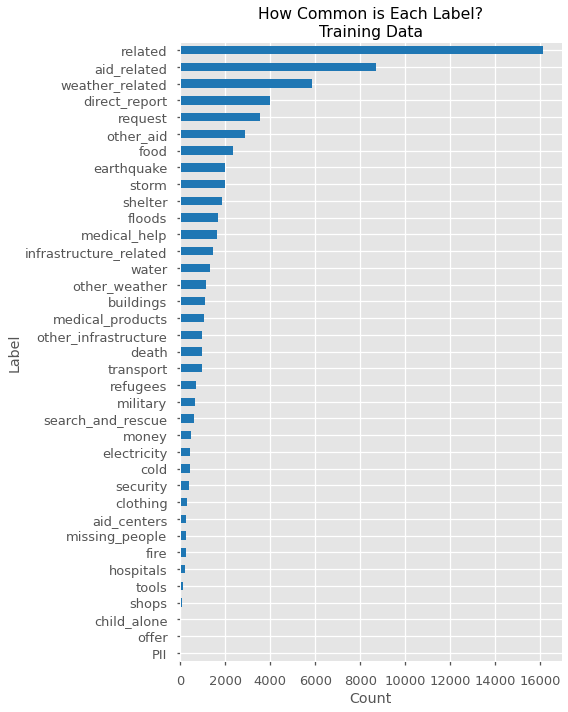

In [11]:
# Plot label-counts within the training data.
label_counts = dw.train[dw.target_columns].sum().sort_values()

fig, ax = plt.subplots(figsize=(8, 10))
label_counts.plot(kind='barh', color=COLORS['blue'])
ax.set(title='How Common is Each Label?\nTraining Data',
       ylabel='Label',
       xlabel='Count')
fig.tight_layout()

### Understand what the columns mean.

In [12]:
dw.column_descriptions

,Description
Column,
id,Unique ID for each individual row
split,"Test, tune, validation split"
message,English text of actual messages related to dis...
original,Text of column 3 in native language as origina...
genre,"Type of message, including direct messages, so..."
related,"Is the message disaster related? 1= yes, 2=no"
PII,"Does the message contain PII? 1= yes, 2=no"
request,"Does the message contain a request? 1= yes, 2=no"
offer,"Does the message contain an offer? 1= yes, 2=no"


- This is pretty predictable. The `message` column has text data (sometimes english translated). Each of the label columns is binary.
  - There is a typo in the label column descriptions: `{1: 'yes', 0: 'no'}`

### What kind of cleaning is required?
1. Drop columns `['id', 'split']`.
2. Examine the text for abnormalities.
3. Process the text data.
 1. Load in a pre-trained GloVe model. (https://nlp.stanford.edu/projects/glove/)
 2. Fit text on the GloVe model and homemade W2V model, trained on the text.

## Preparation
### Text Data

In [13]:
dw.show_data_shapes()

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(21046, 42)
Processed Val Data:
	(2573, 42)
Processed Test Data:
	(2629, 42)


#### Drop unnecessary columns.

In [14]:
dw.drop_column(['id', 'split'])

********************************************************************************
*                                   Success                                    *
********************************************************************************
Columns dropped:
	 ['id', 'split']

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(21046, 40)
Processed Val Data:
	(2573, 40)
Processed Test Data:
	(2629, 40)


#### Examine abnormalities and clean text.

In [15]:
# Clean HTML escape characters (such as ``&#39`` which maps to an apostrophe).
example_string = [string for string in dw.train['message']
                   if '&#' in string][0]
print(example_string)
print(html.unescape(example_string))

Most Eureka homeowners won&#39 t collect on quake insurance The California Earthquake Authority does not expec. http bit.ly 7RY2qT
Most Eureka homeowners won' t collect on quake insurance The California Earthquake Authority does not expec. http bit.ly 7RY2qT


In [16]:
dw.map_to_all('message', html.unescape)

********************************************************************************
*                                   Success                                    *
********************************************************************************


#### Tokenize lower-case text.

In [17]:
# Set new column as copy to maintain original integrity.
for df in dw.processed_data:
    df['all_text_tokenized'] = df['message'].copy()

In [18]:
# Map all text to lower case.
dw.map_to_all('all_text_tokenized', lambda x: x.lower())

********************************************************************************
*                                   Success                                    *
********************************************************************************


In [19]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenize_with_pattern = lambda x: regexp_tokenize(x, pattern)

# Tokenize text into lists.
dw.map_to_all('all_text_tokenized', tokenize_with_pattern)

********************************************************************************
*                                   Success                                    *
********************************************************************************


In [20]:
# Save tokenized text before removing sw and punctuation.
for df in dw.processed_data:
    df['all_text_tokenized_raw'] = df['all_text_tokenized'].copy()

#### Remove StopWords & Punctuation

In [21]:
# Stopwords list.
sw = corpus.stopwords.words('english')
sw += string.digits
sw += string.punctuation

# Define removal function.
not_in_sw = lambda x: [word for word in x if word not in sw]

# Remove stopwords and punctuation.
dw.map_to_all('all_text_tokenized', not_in_sw)

********************************************************************************
*                                   Success                                    *
********************************************************************************


In [22]:
dw.processed_train['all_text_tokenized'][0]

['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pass', 'haiti']

#### Lemmatizer

In [23]:
# Create lemmatizer.
lemmatizer = WordNetLemmatizer()

In [24]:
# Change text to lemmatized version.
dw.map_to_all('all_text_tokenized', 
              lambda lst: [lemmatizer.lemmatize(word) for word in lst])

********************************************************************************
*                                   Success                                    *
********************************************************************************


#### Create total_vocabulary set.

In [25]:
# Set up total_vocabulary set with all unique words in all texts.
total_vocab = set(
    [word for entry in dw.processed_train[dw.predictive_columns].values 
     for word in entry]
)
print('Total unique words:', len(total_vocab))

Total unique words: 28780


#### Set DataWarehouse's column structure - x.

In [26]:
dw.predictive_columns = 'all_text_tokenized'
dw.show_column_split()

********************************************************************************
*                                 Column Split                                 *
********************************************************************************
Predictive Columns (X):
	 all_text_tokenized

Target Columns (Y):
	 ['related', 'PII', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


### Create Word Vectorizer

In [27]:
# Train or load vectors.
if 'word2vec.wordvectors' not in os.listdir('./models/'):
    # Create model.
    word2vec = Word2Vec(dw.X_train(), 
                        size=100, 
                        window=5, 
                        min_count=5, 
                        workers=4,
                        seed=1)

    # Train model.
    word2vec.train(dw.X_train('all_text_tokenized_raw'),
                   total_examples=word2vec.corpus_count, 
                   epochs=200)
    word_vectors = word2vec.wv

    # Save vectors.
    word_vectors.save('./models/word2vec.wordvectors')
    
else:
    # Load vectors.
    word_vectors = KeyedVectors.load('./models/word2vec.wordvectors', mmap='r')

In [28]:
# Test model - Most Similar.
for word in ['earthquake', 'help', 'village', 'water', 'people']:
    print(dis.headerize(word.upper()))
    print('Most Similar Words:')
    for i, similar in enumerate(
        [x[0] for x in word_vectors.most_similar(word)], 1):
        print(f'{i}.\t{similar}')
    print()
    print()

********************************************************************************
*                                  EARTHQUAKE                                  *
********************************************************************************
Most Similar Words:
1.	quake
2.	aftershock
3.	tsunami
4.	earthquakes
5.	temblor
6.	catastrophe
7.	cyclone
8.	tremor
9.	event
10.	disaster


********************************************************************************
*                                     HELP                                     *
********************************************************************************
Most Similar Words:
1.	aid
2.	we
3.	food
4.	whatever
5.	anything
6.	assistance
7.	do
8.	call
9.	tell
10.	tents


********************************************************************************
*                                   VILLAGE                                    *
********************************************************************************
Most Similar Words

In [29]:
# Check.
word_vectors['earthquake']

array([-4.958893  , -1.6894306 , -2.9782546 , -7.171971  ,  1.6368457 ,
       -2.6733797 , -1.4778106 ,  2.8829331 , -3.9022596 ,  3.0896263 ,
        2.1187713 , -1.6080534 , -3.3233106 ,  0.29254755,  0.334381  ,
        0.4777782 ,  4.0040717 ,  2.1589115 ,  4.24441   ,  0.250708  ,
        1.4537616 , -2.622692  , -4.988483  ,  2.7236803 , -4.033444  ,
        0.62815505, -4.5993934 ,  4.773327  , -3.801631  , -4.373962  ,
        0.992394  , -2.8074856 , -4.3827324 ,  1.7027336 ,  2.6824875 ,
       -3.7211564 ,  1.5050607 ,  0.87029123, -3.81475   , -0.2707554 ,
        1.6143057 , -3.8933194 , -2.951618  , -0.62027895, -1.3925467 ,
       -3.1070843 , -5.062437  , -0.89365244, -3.50613   , -1.9218817 ,
        1.1495434 , -0.28382435, -1.3154905 , -2.0050063 ,  1.4891802 ,
        0.54829425, -0.35394973, -1.8802909 ,  5.2774253 ,  2.1347208 ,
       -0.7657049 , -0.7746926 ,  0.15914498, -1.1867669 , -2.3168774 ,
       -0.49145496,  2.415589  , -1.1677201 ,  3.4290705 , -1.47

### Load Pretrained Vectorizer - GloVe

In [30]:
# Load in pretrained GloVe model.
glove = {}

with open('./models/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        line_split = line.split()
        word = line_split[0].decode('utf-8')
        word_vector = np.array(line_split[1:], dtype=np.float32)
        glove[word] = word_vector
            
print('Total words loaded from GloVe:', len(glove))

Total words loaded from GloVe: 400000


In [31]:
# Check.
glove['earthquake']

array([-0.093032 ,  1.6301   ,  0.36645  ,  0.29015  , -0.81781  ,
       -0.46611  ,  0.037282 ,  0.13208  ,  0.13661  ,  1.2091   ,
        0.81466  , -0.12874  ,  0.52387  , -0.024319 ,  0.94072  ,
       -0.12509  , -0.34087  ,  0.19321  , -1.0522   ,  0.62915  ,
       -0.0699   ,  0.14182  ,  0.49985  ,  0.61688  ,  0.027162 ,
        0.22695  , -0.89086  ,  1.4411   , -0.45774  , -0.5922   ,
        0.48147  , -0.4387   ,  0.99552  ,  1.3003   , -1.1123   ,
       -1.4847   ,  0.53476  , -0.22524  , -0.21366  , -0.14612  ,
       -0.50853  ,  0.82284  , -0.075167 , -0.60331  ,  0.86412  ,
        0.15815  ,  0.76075  , -0.28173  ,  0.27679  , -0.43729  ,
       -0.53438  ,  0.081051 ,  0.98763  , -0.28154  , -0.15944  ,
       -1.9562   ,  0.13058  , -0.46506  ,  1.4629   ,  1.262    ,
       -0.46154  ,  1.3625   , -0.40815  , -0.24256  ,  0.21117  ,
        0.57007  , -1.6566   , -0.21043  ,  0.97449  , -0.16146  ,
       -0.33706  ,  0.50539  ,  0.45718  ,  0.2184   ,  0.6955

### Target Data

#### Set DataWarehouse's column structure - y.

In [32]:
dw.target_columns = 'aid_related'
dw.show_column_split()

********************************************************************************
*                                 Column Split                                 *
********************************************************************************
Predictive Columns (X):
	 all_text_tokenized

Target Columns (Y):
	 aid_related


In [33]:
TARGET_NAMES = ['Non-Aid-Related', 'Aid-Related']

********************************************************************************
*                           Aid-Related Value Counts                           *
********************************************************************************


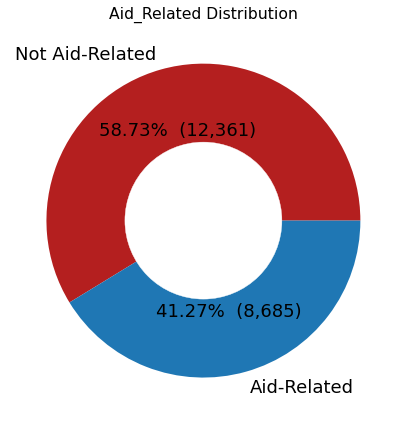

In [34]:
dw.plot_label_distribution('train', 
                           positive_color=COLORS['blue'],
                           negative_color=COLORS['red'],
                           negative_label='Not Aid-Related',
                           positive_label='Aid-Related',
                           title='Aid-Related Value Counts')

## EDA

### Length of Messages.

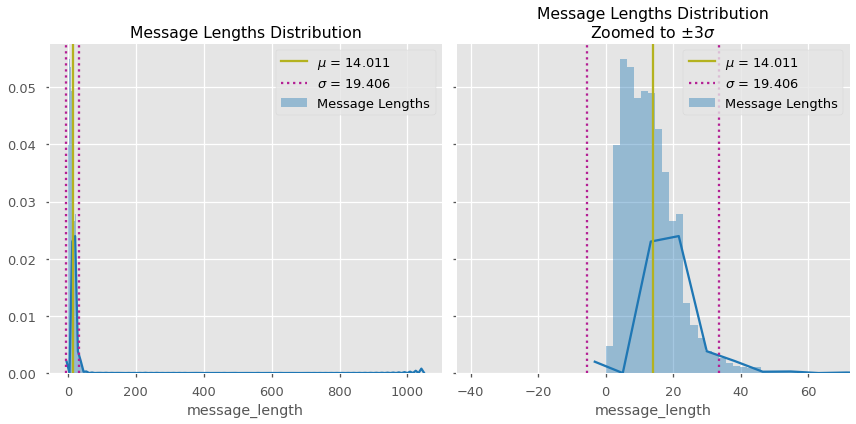

In [35]:
# Series of message lengths.
message_lengths = dw.processed_train[
    dw.predictive_columns].map(lambda x: len(x))
message_lengths.name = 'message_length'

dis.plot_message_lengths_distribution(message_lengths,
                                      dist_color=COLORS['blue'],
                                      mean_color=COLORS['yellow'],
                                      std_color=COLORS['purple'],
                                      pop_label='Message Lengths',
                                      bins=500)

In [36]:
# Examine extreme outliers in length.
message_lengths.sort_values(inplace=True)
longest_10 = message_lengths.tail(10)
shortest_10 = message_lengths.head(10)
print('Longest number of words:')
display(longest_10)
print('Shortest number of words:')
display(shortest_10)

print(dis.headerize('Longest'))
longest_entries = dw.processed_train[
    dw.predictive_columns].loc[longest_10.index].values
print(longest_entries[-1])

print(dis.headerize('Shortest'))
shortest_entries = dw.processed_train[
    dw.predictive_columns].loc[shortest_10.index].values
print(shortest_entries)

Longest number of words:


11828     404
12728     409
16676     459
16926     492
20012     500
13927     560
19916     629
15580     668
12890    1038
16741    1046
Name: message_length, dtype: int64

Shortest number of words:


6076     0
9819     0
5462     1
7594     1
5083     1
6982     1
9740     1
7761     1
18065    1
5739     1
Name: message_length, dtype: int64

********************************************************************************
*                                   Longest                                    *
********************************************************************************


['focus', 'save', 'life', 'fight', 'disease', 'also', 'important', 'address', 'underlying', 'risk', 'solid', 'liquid', 'waste', 'industrial', 'chemical', 'sewage', 'treatment', 'salinization', 'drinking', 'water', 'unicef', 'reported', 'effort', 'combat', 'polio', 'appear', 'resulted', 'eradication', 'northern', 'western', 'eastern', 'province', 'six', 'people', 'drowned', 'overnight', 'assam', 'state', 'tried', 'escape', 'gushing', 'floodwaters', 'bamboo', 'raft', 'state', 'relief', 'rehabilitation', 'minister', 'bhumidhar', 'barman', 'said', 'think', 'evaluation', 'situation', 'idp', 'barrack', 'could', 'next', 'step', 'implement', 'seems', 'reduced', 'focus', 'problem', 'already', 'visited', 'one', 'idp', 'barrack', 'camp', 'found', 'many', 'case', 'scabies', 'cutaneaous', 'mycosis', 'skin', 'allergy', 'family', 'consumption', 'habit', 'changed', 'many', 'case', 'reduced', 'two', 'meal', 'per', 'day', 'already', 'poor', 'water', 'sanitation', 'facility', 'high', 'risk', 'water', 'fo

********************************************************************************
*                                   Shortest                                   *
********************************************************************************
[list([]) list([]) list(['paklascencion']) list(['earthquake'])
 list(['aftershock']) list(['hear']) list(['name']) list(['spot'])
 list(['name']) list(['geqyeygqeqtm'])]


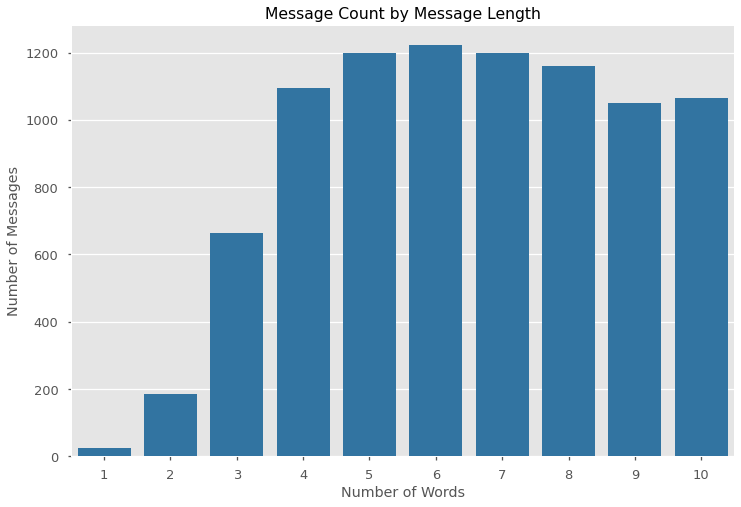

In [37]:
# Plot how many messages contain 10 or fewer words.
x = list(range(1, 10+1))
y = []
for i in x:
    y.append((message_lengths == i).sum())
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, color=COLORS['blue'], ax=ax)
ax.set(title='Message Count by Message Length',
       xlabel='Number of Words',
       ylabel='Number of Messages')
fig.tight_layout()

In [38]:
# Drop messages with fewer than 4 words.
for df in dw.processed_data:
    lengths = df[dw.predictive_columns].map(lambda x: len(x))
    if lengths.index[0] in df.index:
        df.drop(lengths[lengths < 4].index, inplace=True)
        
dw.show_data_shapes()

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(20171, 42)
Processed Val Data:
	(2451, 42)
Processed Test Data:
	(2524, 42)


### Percentage of recognized words. 

Number of recognized words: 232783
Number of words:            292485
Percent:                    0.7958801306049883


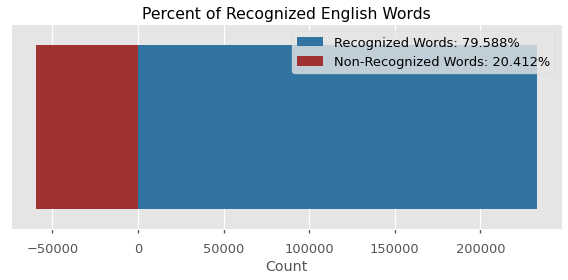

In [39]:
def percent_english(array, verbose=True):
    """Returns (number_english, number_words) from a text array."""
    all_words = set(corpus.words.words())
    num_words = 0
    num_english = 0
    for tokenized_lst in array:
        for word in tokenized_lst:
            num_words += 1
            if word in all_words:
                num_english += 1
    print('Number of recognized words:', num_english)
    print('Number of words:           ', num_words)
    print('Percent:                   ', num_english/num_words)
    return num_english, num_words

# Find number of words recognized in the sorpus words list.
num_recognized, num_words = percent_english(dw.X_train())
num_not_recognized = num_words - num_recognized
pct_rec = num_recognized / num_words
pct_not_rec = num_not_recognized / num_words

# Plot diverging bar chart.
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x=[num_recognized], y=[0], 
            orient='h', 
            ax=ax, 
            color=COLORS['blue'], 
            label=f'Recognized Words: {round(pct_rec*100, 3)}%')
sns.barplot(x=[-num_not_recognized], y=[0], 
            orient='h', 
            ax=ax, 
            color=COLORS['red'], 
            label=f'Non-Recognized Words: {round(pct_not_rec*100, 3)}%')
ax.legend()
ax.set_yticks([])
ax.set(title='Percent of Recognized English Words',
       xlabel='Count')
fig.tight_layout()

### Word Frequencies / WordCloud

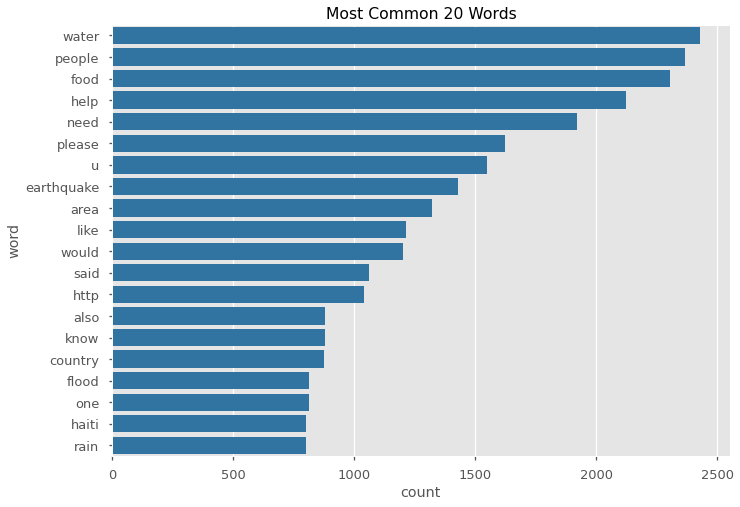

In [40]:
# Plot top 20 words.
all_words = [w for entry in dw.processed_train['all_text_tokenized'].values 
             for w in entry]

freqdist = FreqDist(all_words)
top = pd.DataFrame(freqdist.most_common(20), columns=['word', 'count'])
fig, ax = plt.subplots()
sns.barplot(x='count', y='word', data=top, orient='h', color=COLORS['blue'])
ax.set(title='Most Common 20 Words')
fig.tight_layout()

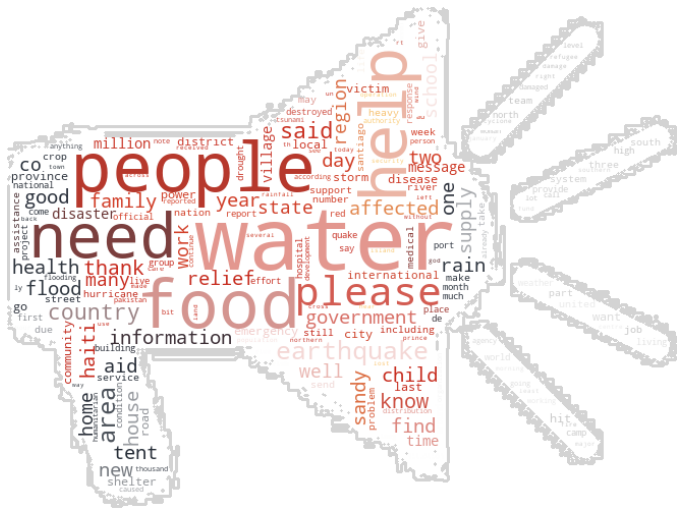

In [41]:
# Image mask.
message_mask = np.array(Image.open('./images/emergency.png'))

# Create wordcloud.
wordcloud = WordCloud(random_state=51, 
                      background_color='white',
                      mode='RGB',
                      mask=message_mask,
                      contour_width=3,
                      contour_color='lightgrey',
                      collocations=False).generate(' '.join(all_words))
image_colors = ImageColorGenerator(message_mask)

# Show.
dis.plot_wordcloud(wordcloud.recolor(color_func=image_colors), figsize=(12,12))

### What are the most common words for each label?

In [42]:
# Create dictionary for each column with all text from the labels.
top_words = {}
for n in (0, 1):
    col_vocab = [
        word for entry in dw.processed_train[
            dw.processed_train[dw.target_columns] == n
        ]['all_text_tokenized'].values
        for word in entry if word not in sw
    ]
    top_words[f'{dw.target_columns}_{str(n)}'] = dict(text=' '.join(col_vocab))
top_words.keys()

dict_keys(['aid_related_0', 'aid_related_1'])

*********************************************
*               AID_RELATED_0               *
*********************************************


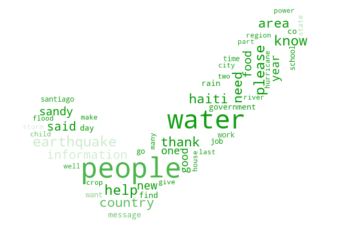

*********************************************
*               AID_RELATED_1               *
*********************************************


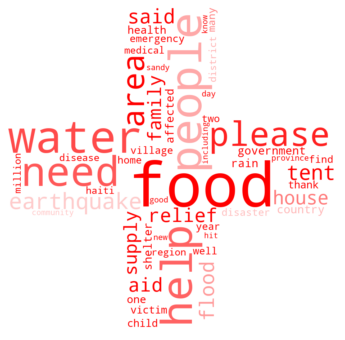

In [43]:
# Set masks.
top_words['aid_related_0']['mask'] = np.array(
    Image.open('./images/check.png'))
top_words['aid_related_1']['mask'] = np.array(
    Image.open('./images/red_cross.png'))

# Create wordclouds and colors.
for label in top_words:
    wc = WordCloud(
        max_words=50,
        random_state=51, 
        background_color='white', 
        mode='RGBA',
        mask=top_words[label]['mask'],
        collocations=False).generate(top_words[label]['text'])
    im_colors = ImageColorGenerator(top_words[label]['mask'])
    
    # Plot wordclouds.
    print(dis.headerize(label.upper(), max_len=45))
    dis.plot_wordcloud(wc.recolor(color_func=im_colors), figsize=(6,6))

### Phrases - Ngrams

********************************************************************************
*                             Most Common Phrases                              *
********************************************************************************


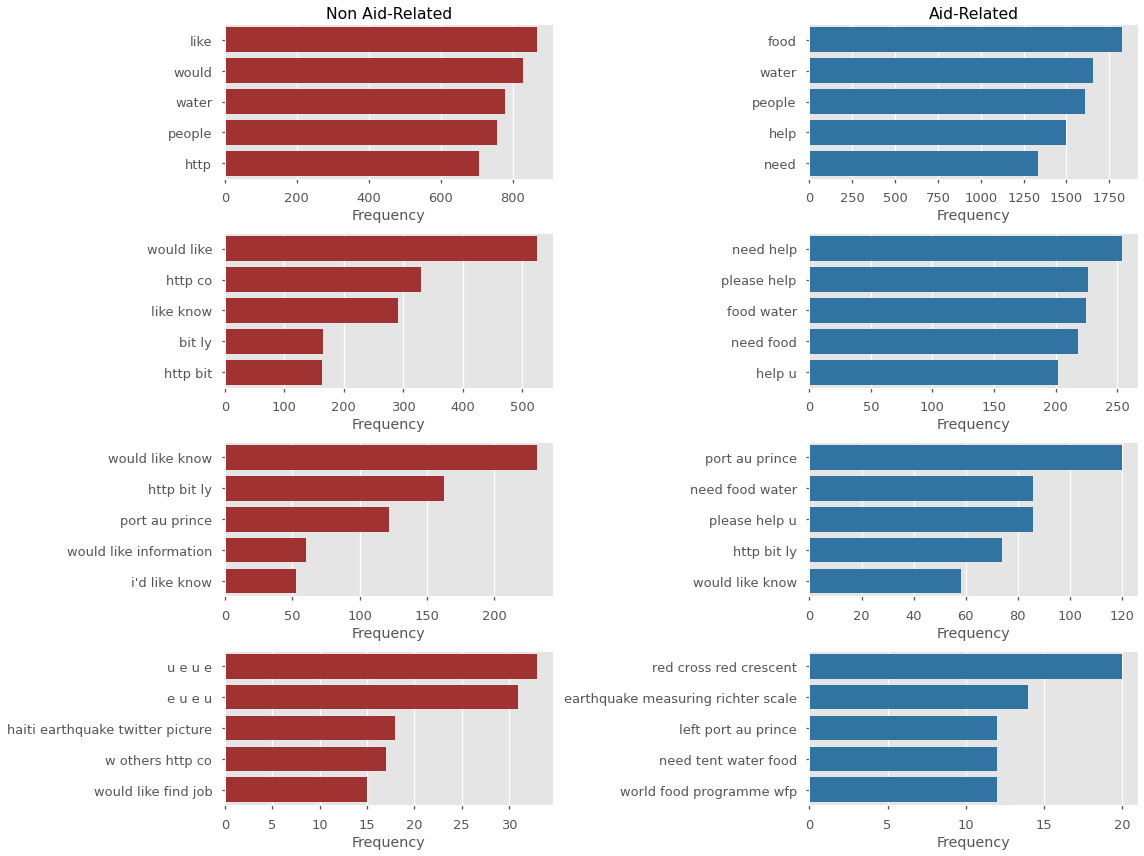

In [44]:
# Get positive and negative labels.
neg = dw.processed_train[
    dw.processed_train[dw.target_columns] == 0][dw.predictive_columns].values
pos = dw.processed_train[
    dw.processed_train[dw.target_columns] == 1][dw.predictive_columns].values

# Plot ngrams.
dis.plot_top_ngrams(4, 
                    pos, neg, 
                    COLORS['blue'], COLORS['red'], 
                    'Aid-Related', 'Non Aid-Related',
                    'Most Common Phrases')

# Modeling

There are two different data processing methods which will be modeled with. The models' metrics will then be compared and a final model will be selected.

The processing methods are:
- **Mean Word Embeddings**
 - There are two types of embedders we will be using:
   1. Pretrained **GloVe** (Global Vectors for Word Representation - https://nlp.stanford.edu/projects/glove/). 
   2. Homemade **Word2Vec** (a vectorizer trained only on the training data).
 - For each message, every word has an n-dimension representation in vector space (in our case, 100-dimension). 
   - For words that don't exist in the *GloVe* model, they are represented as a vector of zeros.
 - The mean of each sentence's words is calculated and a single n-dimensional vector is used to represent the entire message.
- **Tokenization**
 - This is used in Recurrent Neural Networks to utilize the skill of using *ordered sequences* as they exist.
 - These models use an array representation of each word in a message.
 - The word-representations are learned sequentially and meanings are extrapolated from the order they appear, rather than as a single point.

In [45]:
# Create MeanEmbedders
mean_embedder_GLOVE = dis.MeanEmbedder(glove, verbose=True)
mean_embedder_W2V = dis.MeanEmbedder(word_vectors, verbose=True)

Loaded from dictionary.
********************************************************************************
*                                   Success                                    *
********************************************************************************
Embedding model loaded. Dimensions: 100
Loaded from W2V.
********************************************************************************
*                                   Success                                    *
********************************************************************************
Embedding model loaded. Dimensions: 100


## ML - SKLearn

#### Classifier Functions

In [46]:
def create_rfc_step_params():
    """Return a step and paramater dict for a GridSearch pipeline."""
    # RFC pipeline.
    rfc = RandomForestClassifier(n_estimators=100, 
                                 class_weight='balanced', 
                                 random_state=51)
    rfc_step = ('RFC', rfc)

    # RFC GridSearch.
    rfc_params = {
        'RFC__criterion': ['gini', 'entropy'],
        'RFC__min_samples_split': [2, 5, 0.01, 0.05],
        'RFC__max_features': ['sqrt', 'log2', None]
    }
    return (rfc_step, rfc_params)

In [47]:
def create_svc_step_params():
    """Return a step and paramater dict for a GridSearch pipeline."""
    # SVC pipeline.
    svc = SVC(class_weight='balanced', 
              random_state=51)
    svc_step = ('SVC', svc)

    # SVC GridSearch.
    svc_params = {
        'SVC__C': [0.1, 1., 10.],
        'SVC__kernel': ['poly', 'rbf', 'sigmoid'],
        'SVC__gamma': [0.1, 0.5, 1.]
    }
    return (svc_step, svc_params)

In [48]:
def create_logreg_step_params():
    """Return a step and paramater dict for a GridSearch pipeline."""
    # LogReg pipeline.
    logreg = LogisticRegression(class_weight='balanced',
                                random_state=51)
    logreg_step = ('LOGREG', logreg)

    logreg_params = {
        'LOGREG__C': [0.1, 1., 10.],
        'LOGREG__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
    return (logreg_step, logreg_params)

In [49]:
def make_classifiers_lst():
    """Returns a list of tuples: [((`name-str`, `model-skl`), `params-dict`)]"""
    return [
        create_rfc_step_params(),
        create_svc_step_params(),
        create_logreg_step_params()
    ]

### MeanWordEmbedder - GloVe

#### Naive Bayes

********************************************************************************
*                             Naive Bayes - GloVe                              *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.796265  0.658708  0.720984     1424
Aid-Related       0.618225  0.766310  0.684348     1027

   accuracy
   0.703794

              precision    recall  f1-score  support
macro avg      0.707245  0.712509  0.702666     2451
weighted avg   0.721664  0.703794  0.705633     2451


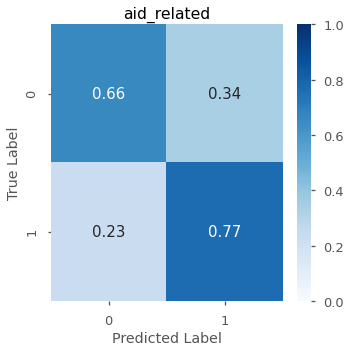

,NB_glove
F1,0.689233
Accuracy,0.698098
Recall,0.745808
Precision,0.640637


In [50]:
# Set up NB Pipeline.
nb = GaussianNB()

ovr_pipe = Pipeline([
    ('MeanWordEmbedder', mean_embedder_GLOVE),
    ('OVR_Logistic_Regression', nb)
])

# Fit / predict.
dis.fit_predict_model(clf=ovr_pipe,
                      X_train=dw.X_train(), 
                      Y_train=dw.Y_train(),
                      X_val=dw.X_val(),
                      Y_val=dw.Y_val(),
                      header='Naive Bayes - GloVe',
                      target_names=TARGET_NAMES,
                      target_column_names=dw.target_columns,
                      plot_confusion=True)

results_df = assign_scores(
    df=results_df, 
    column_name='NB_glove', 
    scores=dis.get_scores(dw.Y_test(), ovr_pipe.predict(dw.X_test())))
results_df

#### GridSearch

In [51]:
SKLEARN_DIR = './models/sklearn/'

In [52]:
FIT_GLOVE_GRIDSEARCH = False

In [53]:
GLOVE_SUFFIX = '_glove'

if FIT_GLOVE_GRIDSEARCH:
    # Run GridSearch on above model specifications.
    best_glove_estimators_lst = dis.gridsearch_classifiers(
        classifiers=make_classifiers_lst(), 
        mean_word_embedder=mean_embedder_GLOVE, 
        directory=SKLEARN_DIR, 
        X_train=dw.X_train(), 
        Y_train=dw.Y_train(), 
        suffix_label=GLOVE_SUFFIX)
    
# If the files are in the directory.
elif any(
    [f.endswith(f'{GLOVE_SUFFIX}.pkl') for f in os.listdir(SKLEARN_DIR)]
    ):
    # Load in models.
    best_glove_estimators_lst = [
        (name, joblib.load(f'{SKLEARN_DIR}{name}{GLOVE_SUFFIX}.pkl')) 
        for (name, clf), _ in make_classifiers_lst()
    ]

# The models could not be found and `FIT_GLOVE_GRIDSEARCH` is False.
else:
    raise Exception(f'''Models not found in {SKLEARN_DIR}. 
Put the files in the directory or set `FIT_SKLEARN_MODELS` to True''')

********************************************************************************
*                                 RFC - GloVe                                  *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.785362  0.783708  0.784534     1424
Aid-Related       0.700971  0.703019  0.701993     1027

   accuracy
   0.749898

              precision    recall  f1-score  support
macro avg      0.743167  0.743363  0.743264     2451
weighted avg   0.750001  0.749898  0.749949     2451


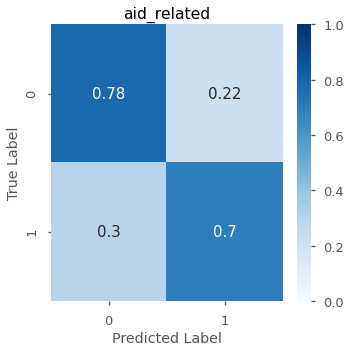

********************************************************************************
*                                 SVC - GloVe                                  *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.827085  0.759129  0.791651     1424
Aid-Related       0.700175  0.779942  0.737909     1027

   accuracy
    0.76785

              precision    recall  f1-score  support
macro avg      0.763630  0.769535  0.764780     2451
weighted avg   0.773908  0.767850  0.769133     2451


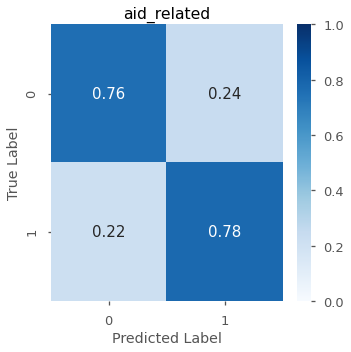

********************************************************************************
*                                LOGREG - GloVe                                *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.853239  0.591994  0.699005     1424
Aid-Related       0.602871  0.858812  0.708434     1027

   accuracy
   0.703794

              precision    recall  f1-score  support
macro avg      0.728055  0.725403  0.703719     2451
weighted avg   0.748331  0.703794  0.702956     2451


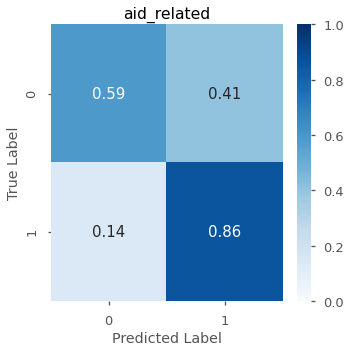

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove
F1,0.689233,0.732880,0.769165,0.733208
Accuracy,0.698098,0.766640,0.787639,0.718304
Recall,0.745808,0.713151,0.788173,0.862312
Precision,0.640637,0.753731,0.751051,0.637728


In [54]:
# Show model scores.
for name, clf in best_glove_estimators_lst:
    dis.show_scores(y_true=dw.Y_val(), 
                    y_pred=clf.predict(dw.X_val()),
                    conf_matrix=True,
                    header=f'{name} - GloVe',
                    target_names=TARGET_NAMES,
                    column_names=dw.target_columns)
    
    results_df = assign_scores(
        df=results_df, 
        column_name=f'{name}_glove', 
        scores=dis.get_scores(dw.Y_test(), clf.predict(dw.X_test())))

results_df

Clearly the SVC outperformed the other model types substantially. 

It is the best option for all metrics except performing *very* slightly worse with it's precision to the RFC.

### MeanWordEmbedder - Homemade Word Vectorizer

#### Naive Bayes

********************************************************************************
*                            Naive Bayes - Word2Vec                            *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.794895  0.612360  0.691789     1424
Aid-Related       0.592319  0.780915  0.673667     1027

   accuracy
   0.682987

              precision    recall  f1-score  support
macro avg      0.693607  0.696637  0.682728     2451
weighted avg   0.710013  0.682987  0.684195     2451


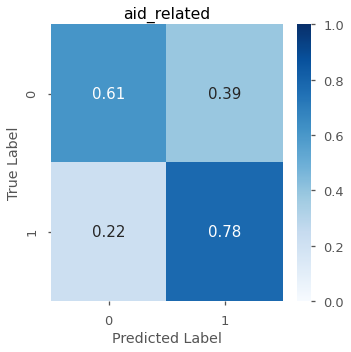

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v
F1,0.689233,0.732880,0.769165,0.733208,0.707668
Accuracy,0.698098,0.766640,0.787639,0.718304,0.709984
Recall,0.745808,0.713151,0.788173,0.862312,0.781995
Precision,0.640637,0.753731,0.751051,0.637728,0.646244


In [55]:
# Set up NB Pipeline.
nb = GaussianNB()

ovr_pipe = Pipeline([
    ('MeanWordEmbedder', mean_embedder_W2V),
    ('OVR_Logistic_Regression', nb)
])

# Fit / predict.
dis.fit_predict_model(clf=ovr_pipe,
                      X_train=dw.X_train(), 
                      Y_train=dw.Y_train(),
                      X_val=dw.X_val(),
                      Y_val=dw.Y_val(),
                      header='Naive Bayes - Word2Vec',
                      target_names=TARGET_NAMES,
                      target_column_names=dw.target_columns,
                      plot_confusion=True)

results_df = assign_scores(
    df=results_df, 
    column_name='NB_w2v', 
    scores=dis.get_scores(dw.Y_test(), ovr_pipe.predict(dw.X_test())))
results_df

#### GridSearch

In [56]:
FIT_W2V_GRIDSEARCH = False

In [57]:
W2V_SUFFIX = '_w2v'

if FIT_W2V_GRIDSEARCH:
    # Run GridSearch on above model specifications.
    best_w2v_estimators_lst = dis.gridsearch_classifiers(
        classifiers=make_classifiers_lst(), 
        mean_word_embedder=mean_embedder_W2V, 
        directory=SKLEARN_DIR, 
        X_train=dw.X_train(), 
        Y_train=dw.Y_train(), 
        suffix_label=W2V_SUFFIX)
    
# If the files are in the directory.
elif any(
    [f.endswith(f'{W2V_SUFFIX}.pkl') for f in os.listdir(SKLEARN_DIR)]
    ):
    # Load in models.
    best_w2v_estimators_lst = [
        (name, joblib.load(f'{SKLEARN_DIR}{name}{W2V_SUFFIX}.pkl')) 
        for (name, clf), _ in make_classifiers_lst()
    ]

# The models could not be found and `FIT_W2V_GRIDSEARCH` is False.
else:
    raise Exception(f'''Models not found in {SKLEARN_DIR}. 
Put the files in the directory or set `FIT_W2V_GRIDSEARCH` to True''')

********************************************************************************
*                                  RFC - W2V                                   *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.763963  0.806882  0.784836     1424
Aid-Related       0.709609  0.654333  0.680851     1027

   accuracy
   0.742962

              precision    recall  f1-score  support
macro avg      0.736786  0.730608  0.732844     2451
weighted avg   0.741188  0.742962  0.741265     2451


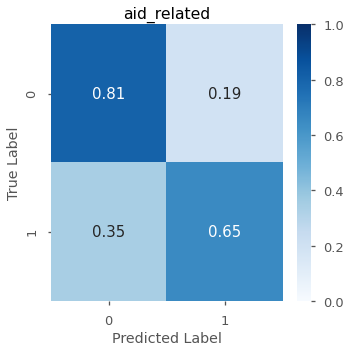

********************************************************************************
*                                  SVC - W2V                                   *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.779674  0.705758  0.740877     1424
Aid-Related       0.639415  0.723466  0.678849     1027

   accuracy
   0.713178

              precision    recall  f1-score  support
macro avg      0.709544  0.714612  0.709863     2451
weighted avg   0.720904  0.713178  0.714887     2451


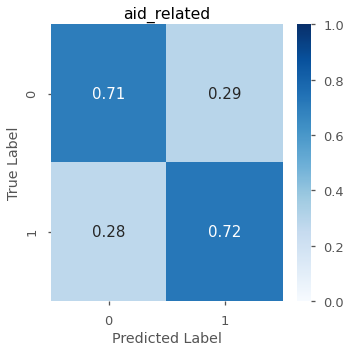

********************************************************************************
*                                 LOGREG - W2V                                 *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.793025  0.734551  0.762669     1424
Aid-Related       0.666078  0.734177  0.698472     1027

   accuracy
   0.734394

              precision    recall  f1-score  support
macro avg      0.729551  0.734364  0.730570     2451
weighted avg   0.739833  0.734394  0.735769     2451


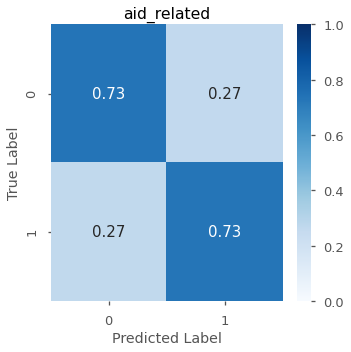

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v,RFC_w2v,SVC_w2v,LOGREG_w2v
F1,0.689233,0.732880,0.769165,0.733208,0.707668,0.722543,0.707053,0.729776
Accuracy,0.698098,0.766640,0.787639,0.718304,0.709984,0.771791,0.731775,0.751189
Recall,0.745808,0.713151,0.788173,0.862312,0.781995,0.661959,0.721094,0.748455
Precision,0.640637,0.753731,0.751051,0.637728,0.646244,0.795334,0.693548,0.712007


In [58]:
# Show model scores.
for name, clf in best_w2v_estimators_lst:
    dis.show_scores(y_true=dw.Y_val(), 
                    y_pred=clf.predict(dw.X_val()),
                    conf_matrix=True,
                    target_names=TARGET_NAMES,
                    header=f'{name} - W2V',
                    column_names=dw.target_columns)
    
    results_df = assign_scores(
        df=results_df, 
        column_name=f'{name}{W2V_SUFFIX}', 
        scores=dis.get_scores(dw.Y_test(), clf.predict(dw.X_test())))

results_df

## TensorFlow Neural Network

### NN Functions

In [59]:
def build_simple_nn():
    """Returns a compiled model with two Dense layers and a sigmoid output."""
    model = models.Sequential()
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    return model

In [60]:
def build_multilayer_nn(dense_layers=10):
    """Returns a compiled model with multiple "cascading" layers.
(Each layer should have more nodes than the following node.
The final layer will have 2 nodes.)"""
    node_sizes = [2]
    for _ in range(dense_layers-1):
        node_sizes.append(int(node_sizes[-1] + (node_sizes[-1] * 0.75)))
    print(dis.headerize(f'Nodes Per Layer: {node_sizes[::-1]}'))
    
    model = models.Sequential()
    for n in node_sizes[::-1]:
        model.add(layers.Dense(n, activation='relu'))
        model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    return model

```python
>>> # `build_multilayer_nn` function example:
>>> for d in range(1, 7):
...     node_sizes = [2]
...     for _ in range(d-1):
...         node_sizes.append(int(node_sizes[-1] + (node_sizes[-1] * 0.75)))
...     print(node_sizes[::-1])
[2]
[3, 2]
[5, 3, 2]
[8, 5, 3, 2]
[14, 8, 5, 3, 2]
[24, 14, 8, 5, 3, 2]
```

In [61]:
# Metrics
metrics = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [62]:
# Create weights dict for slight class imbalance.
classes = [0, 1]
WEIGHTS_DCT = {
    k: v for k, v in 
    zip(classes, compute_class_weight('balanced', classes, dw.Y_train()))
}
WEIGHTS_DCT

{0: 0.8670477991746905, 1: 1.1811102002576415}

### MeanWordEmbedder - GloVe

In [63]:
TRAIN_GLOVE_NN = False

##### Processing

In [64]:
# Transform GloVe data.
X_train_glove = mean_embedder_GLOVE.transform(dw.X_train())
X_val_glove = mean_embedder_GLOVE.transform(dw.X_val())
X_test_glove = mean_embedder_GLOVE.transform(dw.X_test())

X_train_glove.shape, X_val_glove.shape, X_test_glove.shape

((20171, 100), (2451, 100), (2524, 100))

##### Modeling

In [65]:
# Create models.
simple_glove_model = build_simple_nn()
multilayer_glove_model = build_multilayer_nn(6)

********************************************************************************
*                    Nodes Per Layer: [24, 14, 8, 5, 3, 2]                     *
********************************************************************************


In [66]:
simple_glove_path = './models/tensorflow/simple_glove_model.h5'
multilayer_glove_path = './models/tensorflow/multilayer_glove_model.h5'
simple_glove_dir = os.path.dirname(simple_glove_path)
multilayer_glove_dir = os.path.dirname(multilayer_glove_path)

# Train models with mean word embeddings and GloVe vectors.
if TRAIN_GLOVE_NN:
    simple_glove_history = dis.train_dump_model(
        name='simple_glove_model', 
        model=simple_glove_model, 
        X_train=X_train_glove, 
        y_train=dw.Y_train(), 
        X_val=X_val_glove, 
        y_val=dw.Y_val(), 
        class_weight=WEIGHTS_DCT,
        f_path=simple_glove_path
        )
    multilayer_glove_history = dis.train_dump_model(
        name='multilayer_glove_model', 
        model=multilayer_glove_model, 
        X_train=X_train_glove, 
        y_train=dw.Y_train(), 
        X_val=X_val_glove, 
        y_val=dw.Y_val(), 
        class_weight=WEIGHTS_DCT,
        f_path=multilayer_glove_path
        )

# Load pretrained models.
else:
    simple_glove_model = load_model(simple_glove_path)
    multilayer_glove_model = load_model(multilayer_glove_path)
    
    simple_glove_history = joblib.load(
        simple_glove_dir+'/simple_glove_model_history.pkl')
    multilayer_glove_history = joblib.load(
        multilayer_glove_dir+'/multilayer_glove_model_history.pkl')

********************************************************************************
*                       simple_model - NN - MWE - GloVe                        *
********************************************************************************


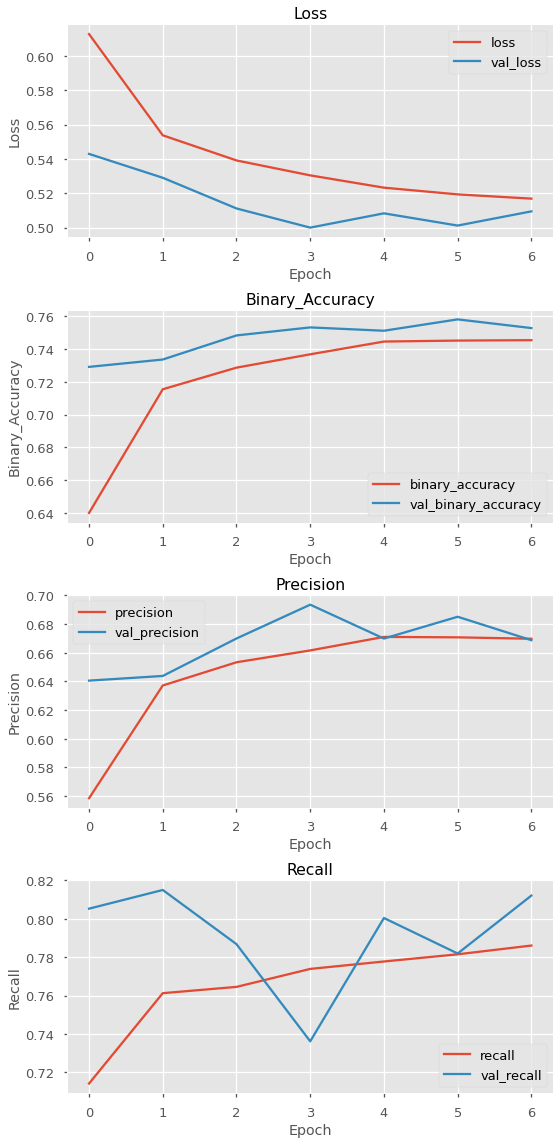

********************************************************************************
*                       simple_model - NN - MWE - GloVe                        *
********************************************************************************
   precision    recall  f1-score  support
0   0.839701  0.709972  0.769406     1424
1   0.668805  0.812074  0.733509     1027

   accuracy
   0.752754

              precision    recall  f1-score  support
macro avg      0.754253  0.761023  0.751458     2451
weighted avg   0.768093  0.752754  0.754365     2451


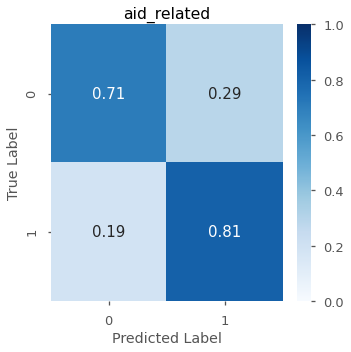

********************************************************************************
*                     multilayer_model - NN - MWE - GloVe                      *
********************************************************************************


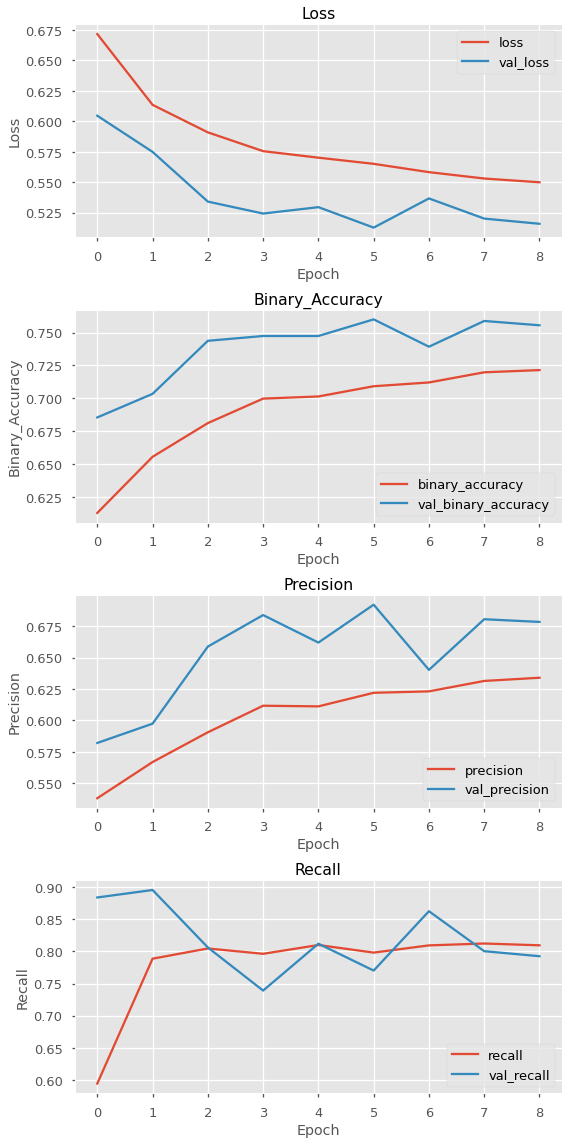

********************************************************************************
*                     multilayer_model - NN - MWE - GloVe                      *
********************************************************************************
   precision    recall  f1-score  support
0   0.829736  0.728933  0.776075     1424
1   0.678333  0.792600  0.731028     1027

   accuracy
    0.75561

              precision    recall  f1-score  support
macro avg      0.754035  0.760766  0.753552     2451
weighted avg   0.766296  0.755610  0.757200     2451


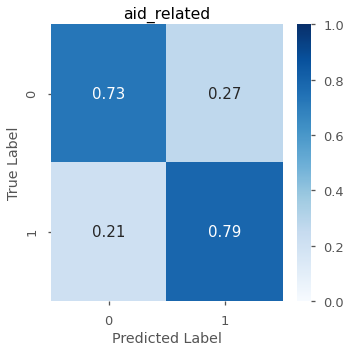

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v,RFC_w2v,SVC_w2v,LOGREG_w2v,simple_model_NN_glove,multilayer_model_NN_glove
F1,0.689233,0.732880,0.769165,0.733208,0.707668,0.722543,0.707053,0.729776,0.764513,0.772460
Accuracy,0.698098,0.766640,0.787639,0.718304,0.709984,0.771791,0.731775,0.751189,0.771791,0.785261
Recall,0.745808,0.713151,0.788173,0.862312,0.781995,0.661959,0.721094,0.748455,0.825243,0.812004
Precision,0.640637,0.753731,0.751051,0.637728,0.646244,0.795334,0.693548,0.712007,0.712110,0.736589


In [67]:
# Evaluate all mean-embedded GloVe models.
glove_nn_lst = [
    ('simple_model', simple_glove_model, simple_glove_history),
    ('multilayer_model', multilayer_glove_model, multilayer_glove_history)
]

for name, model, history in glove_nn_lst:
    y_test_pred = dis.evaluate_nn(model, 
                                  history, 
                                  X_val_glove, 
                                  dw.Y_val(), 
                                  X_test_glove, 
                                  header=f'{name} - NN - MWE - GloVe', 
                                  column_names=dw.target_columns)

    results_df = assign_scores(
        df=results_df, 
        column_name=f'{name}_NN_glove', 
        scores=dis.get_scores(dw.Y_test(), y_test_pred))

results_df

### MeanWordEmbedder - Homemade Word Vectorizer

In [68]:
TRAIN_W2V_NN = False

##### Processing

In [69]:
# Set up data.
X_train_w2v = mean_embedder_W2V.transform(dw.X_train())
X_val_w2v = mean_embedder_W2V.transform(dw.X_val())
X_test_w2v = mean_embedder_W2V.transform(dw.X_test())

X_train_w2v.shape, X_val_w2v.shape, X_test_w2v.shape

((20171, 100), (2451, 100), (2524, 100))

##### Modeling

In [70]:
# Create models.
simple_w2v_model = build_simple_nn()
multilayer_w2v_model = build_multilayer_nn(6)

for model in (simple_w2v_model, multilayer_w2v_model):
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

********************************************************************************
*                    Nodes Per Layer: [24, 14, 8, 5, 3, 2]                     *
********************************************************************************


In [71]:
simple_w2v_path = './models/tensorflow/simple_w2v_model.h5'
multilayer_w2v_path = './models/tensorflow/multilayer_w2v_model.h5'
simple_w2v_dir = os.path.dirname(simple_w2v_path)
multilayer_w2v_dir = os.path.dirname(multilayer_w2v_path)

# Train models with mean word embeddings and homemade vectors. 
if TRAIN_W2V_NN:
    simple_w2v_history = dis.train_dump_model(
        name='simple_w2v_model', 
        model=simple_w2v_model, 
        X_train=X_train_w2v, 
        y_train=dw.Y_train(), 
        X_val=X_val_w2v, 
        y_val=dw.Y_val(), 
        class_weight=WEIGHTS_DCT,
        f_path=simple_w2v_path
        )
    multilayer_w2v_history = dis.train_dump_model(
        name='multilayer_w2v_model', 
        model=multilayer_w2v_model, 
        X_train=X_train_w2v, 
        y_train=dw.Y_train(), 
        X_val=X_val_w2v, 
        y_val=dw.Y_val(), 
        class_weight=WEIGHTS_DCT,
        f_path=multilayer_w2v_path
        )
    
# Load pretrained models.
else:
    simple_w2v_model = load_model(simple_w2v_path)
    multilayer_w2v_model = load_model(multilayer_w2v_path)
    
    simple_w2v_history = joblib.load(
        simple_w2v_dir+'/simple_w2v_model_history.pkl')
    multilayer_w2v_history = joblib.load(
        multilayer_w2v_dir+'/multilayer_w2v_model_history.pkl')

********************************************************************************
*                        simple_model - NN - MWE - W2V                         *
********************************************************************************


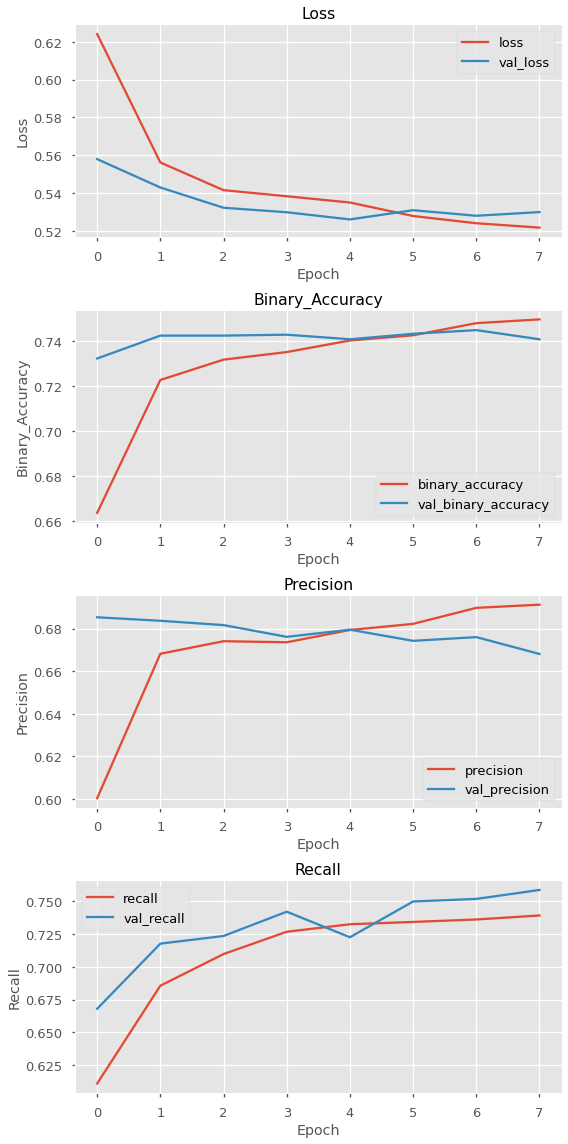

********************************************************************************
*                        simple_model - NN - MWE - W2V                         *
********************************************************************************
   precision   recall  f1-score  support
0   0.807004  0.72823  0.765596     1424
1   0.668096  0.75852  0.710442     1027

   accuracy
   0.740922

              precision    recall  f1-score  support
macro avg       0.73755  0.743375  0.738019     2451
weighted avg    0.74880  0.740922  0.742486     2451


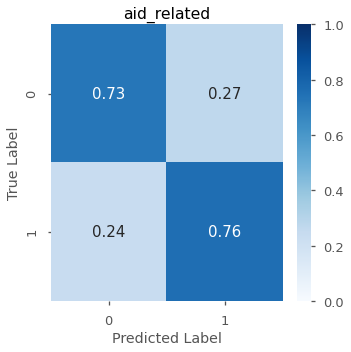

********************************************************************************
*                      multilayer_model - NN - MWE - W2V                       *
********************************************************************************


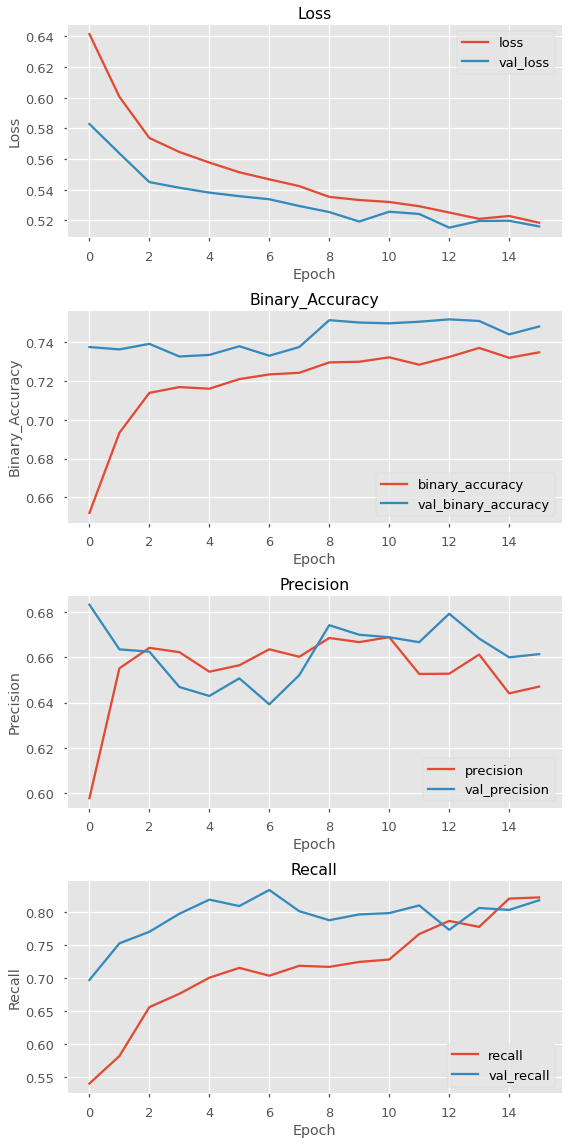

********************************************************************************
*                      multilayer_model - NN - MWE - W2V                       *
********************************************************************************
   precision    recall  f1-score  support
0   0.841660  0.698034  0.763148     1424
1   0.661417  0.817916  0.731389     1027

   accuracy
   0.748266

              precision    recall  f1-score  support
macro avg      0.751538  0.757975  0.747268     2451
weighted avg   0.766136  0.748266  0.749840     2451


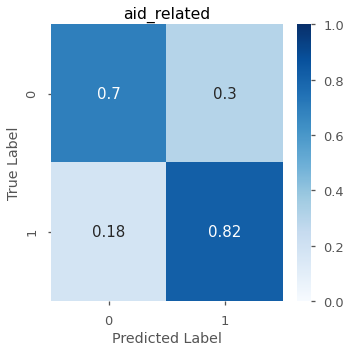

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v,RFC_w2v,SVC_w2v,LOGREG_w2v,simple_model_NN_glove,multilayer_model_NN_glove,simple_model_NN_w2v,multilayer_model_NN_w2v
F1,0.689233,0.732880,0.769165,0.733208,0.707668,0.722543,0.707053,0.729776,0.764513,0.772460,0.754296,0.762413
Accuracy,0.698098,0.766640,0.787639,0.718304,0.709984,0.771791,0.731775,0.751189,0.771791,0.785261,0.773376,0.770602
Recall,0.745808,0.713151,0.788173,0.862312,0.781995,0.661959,0.721094,0.748455,0.825243,0.812004,0.774934,0.819947
Precision,0.640637,0.753731,0.751051,0.637728,0.646244,0.795334,0.693548,0.712007,0.712110,0.736589,0.734728,0.712423


In [72]:
# Evaluate mean-embedded W2V models.
w2v_nn_dct = {
    'simple_model': {
        'model': simple_w2v_model,
        'history': simple_w2v_history
    },
    'multilayer_model': {
        'model': multilayer_w2v_model,
        'history': multilayer_w2v_history
    }
}

for name in w2v_nn_dct:
    y_test_pred = dis.evaluate_nn(w2v_nn_dct[name]['model'], 
                                  w2v_nn_dct[name]['history'], 
                                  X_val_w2v, 
                                  dw.Y_val(), 
                                  X_test_w2v, 
                                  header=f'{name} - NN - MWE - W2V', 
                                  column_names=dw.target_columns)

    results_df = assign_scores(
        df=results_df, 
        column_name=f'{name}_NN_w2v', 
        scores=dis.get_scores(dw.Y_test(), y_test_pred))

results_df

### Padded & Tokenized - RNN

In [73]:
TRAIN_RNN = False

##### Processing

In [74]:
# Create padded tokens of 'all_text' from DataWarehouse.
all_text_lst = [
    dw.X_train('all_text_tokenized_raw'), 
    dw.X_val('all_text_tokenized_raw'), 
    dw.X_test('all_text_tokenized_raw')
]
max_length = 65

# Create tokenizer and transform text data.
tokenizer, (X_train_tok, X_val_tok, X_test_tok) = dis.tokenize_series(
    dw.X_train('all_text_tokenized_raw'),
    all_text_lst,
    pad_sequences_maxlen=max_length)

# Save tokenizer.
joblib.dump(tokenizer, './models/tokenizer/tokenizer.pkl')

********************************************************************************
*                           Tokenizer Created & Fit                            *
********************************************************************************
Ex:


[['weather',
  'update',
  'a',
  'cold',
  'front',
  'from',
  'cuba',
  'that',
  'could',
  'pass',
  'over',
  'haiti'],
 ['says',
  'west',
  'side',
  'of',
  'haiti',
  'rest',
  'of',
  'the',
  'country',
  'today',
  'and',
  'tonight']]

********************************************************************************
*                              Series' Tokenized                               *
********************************************************************************
Ex:


[[191, 1845, 6, 422, 905, 21, 2656, 14, 130, 552, 74, 64],
 [519, 290, 949, 4, 64, 1315, 4, 1, 78, 265, 2, 1172]]

********************************************************************************
*                                  Tokenized                                   *
********************************************************************************
Ex:


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  191, 1845,
           6,  422,  905,   21, 2656,   14,  130,  552,   74,   64],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  519,  290,
         949,    4,   64, 1315,    4,    1,   78,  265,    2, 1172]])

********************************************************************************
*                                   Finished                                   *
********************************************************************************


['./models/tokenizer/tokenizer.pkl']

In [75]:
# Create w2v dictionary in same format as glove.
w2v_dct = {word: word_vectors[word] for word in word_vectors.vocab}

In [76]:
# Set num_words & embedding size for models.
glove_vocab_len, glove_n_dim, glove_matrix = dis.make_embedding_matrix(
    glove, tokenizer.word_index)
w2v_vocab_len, w2v_n_dim, w2v_matrix = dis.make_embedding_matrix(
    w2v_dct, tokenizer.word_index)

In [77]:
glove_matrix.shape, w2v_matrix.shape

((30507, 100), (30507, 100))

##### Modeling

In [78]:
# Set variables for modeling.
rnn_glove_path = './models/tensorflow/rnn_glove.h5'
rnn_w2v_path = './models/tensorflow/rnn_w2v.h5'

rnn_dct = {
    'glove': {'model': None, 
              'history': None,
              'params': (glove_vocab_len, glove_n_dim, glove_matrix),
              'path': rnn_glove_path,
              'dir': os.path.dirname(rnn_glove_path)},
    'w2v': {'model': None, 
            'history': None,
            'params': (w2v_vocab_len, w2v_n_dim, w2v_matrix),
            'path': rnn_w2v_path,
            'dir': os.path.dirname(rnn_w2v_path)}
}

In [79]:
for name in rnn_dct:
    vocab_len, n_dim, matrix = rnn_dct[name]['params']
    
    model = models.Sequential()
    model.add(layers.Embedding(vocab_len, 
                               n_dim, 
                               weights=[matrix], 
                               input_length=max_length, 
                               trainable=False))
    model.add(layers.LSTM(glove_n_dim, 
                          batch_size=1, 
                          input_shape=(None, glove_n_dim), 
                          return_sequences=True))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.TimeDistributed(
        layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(
        layers.Dense(16, activation='relu')))
    model.add(layers.TimeDistributed(
        layers.Dense(8, activation='relu')))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    rnn_dct[name]['model'] = model

In [80]:
if TRAIN_RNN:
    for name in rnn_dct:
        model_history = dis.train_dump_model(
            name=f'rnn_{name}', 
            model=rnn_dct[name]['model'], 
            X_train=X_train_tok, 
            y_train=dw.Y_train(), 
            X_val=X_val_tok, 
            y_val=dw.Y_val(), 
            class_weight=WEIGHTS_DCT,
            f_path=rnn_dct[name]['path']
            )
        rnn_dct[name]['history'] = model_history
else:
    for name in rnn_dct:
        rnn_dct[name]['model'] = load_model(rnn_dct[name]['path'])
        rnn_dct[name]['history'] = joblib.load(
            rnn_dct[name]['dir']+f'/rnn_{name}_history.pkl')

********************************************************************************
*                                 RNN - glove                                  *
********************************************************************************


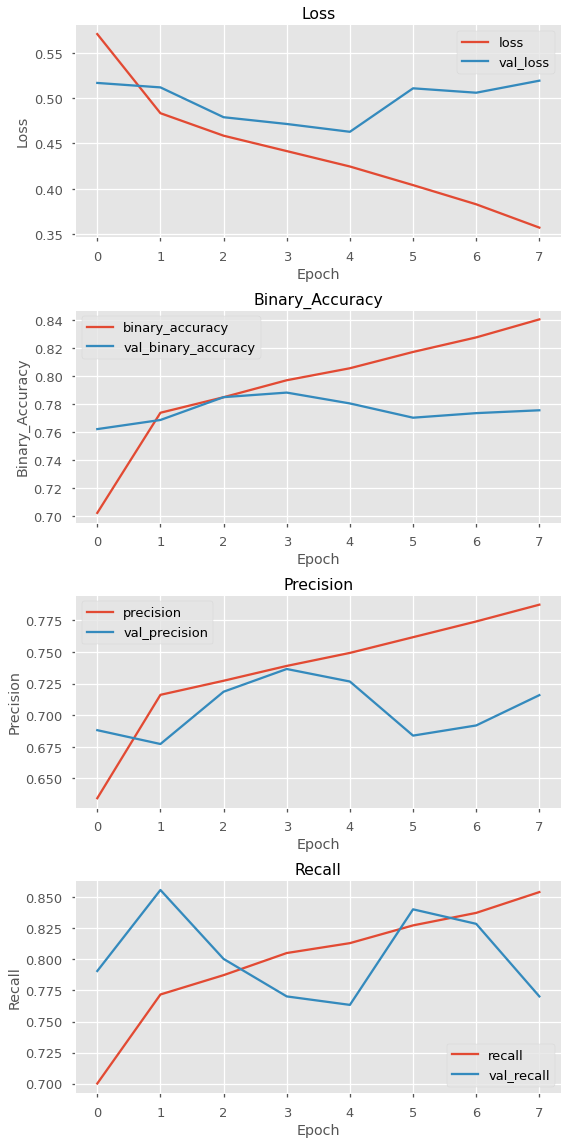

********************************************************************************
*                                 RNN - glove                                  *
********************************************************************************
   precision    recall  f1-score  support
0   0.824666  0.779494  0.801444     1424
1   0.715837  0.770204  0.742026     1027

   accuracy
   0.775602

              precision    recall  f1-score  support
macro avg      0.770251  0.774849  0.771735     2451
weighted avg   0.779065  0.775602  0.776547     2451


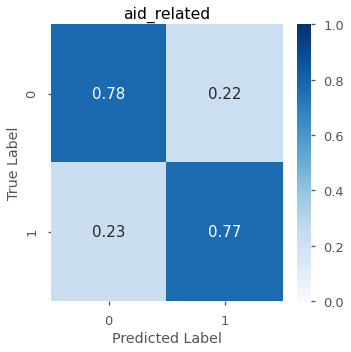

********************************************************************************
*                                  RNN - w2v                                   *
********************************************************************************


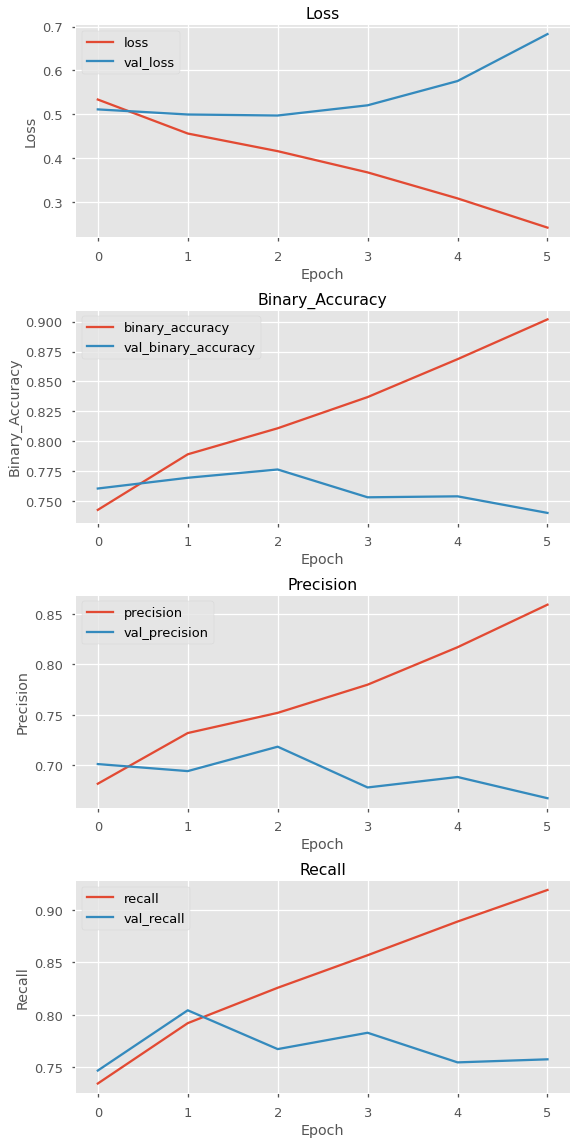

********************************************************************************
*                                  RNN - w2v                                   *
********************************************************************************
   precision    recall  f1-score  support
0   0.806226  0.727528  0.764858     1424
1   0.667238  0.757546  0.709530     1027

   accuracy
   0.740106

              precision    recall  f1-score  support
macro avg      0.736732  0.742537  0.737194     2451
weighted avg   0.747988  0.740106  0.741675     2451


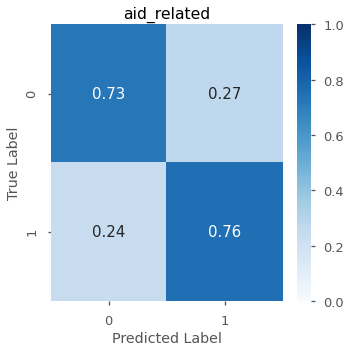

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v,RFC_w2v,SVC_w2v,LOGREG_w2v,simple_model_NN_glove,multilayer_model_NN_glove,simple_model_NN_w2v,multilayer_model_NN_w2v,RNN_glove,RNN_w2v
F1,0.689233,0.732880,0.769165,0.733208,0.707668,0.722543,0.707053,0.729776,0.764513,0.772460,0.754296,0.762413,0.807064,0.747631
Accuracy,0.698098,0.766640,0.787639,0.718304,0.709984,0.771791,0.731775,0.751189,0.771791,0.785261,0.773376,0.770602,0.826862,0.767829
Recall,0.745808,0.713151,0.788173,0.862312,0.781995,0.661959,0.721094,0.748455,0.825243,0.812004,0.774934,0.819947,0.806708,0.766108
Precision,0.640637,0.753731,0.751051,0.637728,0.646244,0.795334,0.693548,0.712007,0.712110,0.736589,0.734728,0.712423,0.807420,0.730025


In [81]:
for name in rnn_dct:
    y_test_pred = dis.evaluate_nn(rnn_dct[name]['model'], 
                                  rnn_dct[name]['history'], 
                                  X_val_tok, 
                                  dw.Y_val(), 
                                  X_test_tok, 
                                  header=f'RNN - {name}', 
                                  column_names=dw.target_columns)

    results_df = assign_scores(
        df=results_df, 
        column_name=f'RNN_{name}', 
        scores=dis.get_scores(dw.Y_test(), y_test_pred))

results_df

# Interpret

In [82]:
RESULTS = results_df.T

In [83]:
RESULTS.sort_values('F1', ascending=False, inplace=True)

In [84]:
RESULTS.style.background_gradient('Blues')

,F1,Accuracy,Recall,Precision
RNN_glove,0.807064,0.826862,0.806708,0.80742
multilayer_model_NN_glove,0.77246,0.785261,0.812004,0.736589
SVC_glove,0.769165,0.787639,0.788173,0.751051
simple_model_NN_glove,0.764513,0.771791,0.825243,0.71211
multilayer_model_NN_w2v,0.762413,0.770602,0.819947,0.712423
simple_model_NN_w2v,0.754296,0.773376,0.774934,0.734728
RNN_w2v,0.747631,0.767829,0.766108,0.730025
LOGREG_glove,0.733208,0.718304,0.862312,0.637728
RFC_glove,0.73288,0.76664,0.713151,0.753731
LOGREG_w2v,0.729776,0.751189,0.748455,0.712007


- Overall, **RNN_glove** (the RNN accompanied by the GloVe weights) performed clearly best overall.
 - On the test set:
   - 80.67% of `aid-related` messages were found.
   - 80.74% of `aid-related` predictions were correct.
   - 82.69% overall accuracy.
- **SVC_glove** (the SVC using Mean Word Embeddings and the GloVe model) performed exceptionally well and was the best of the ML models.
- The GloVe model lead to better results than the homemade *W2V* word embedder.

***
### Model Summary

The results of the modeling is mostly predictable - Neural Networks outperform machine learning models on the whole. However, it is important to note the impressive scores of the **SVC** with Mean Embeddings from the GloVe model. It was overall the third-best model. It was a very solid choice for solving this problem and surpassed many Neural Networks.

You can tell that even though the Logistic Regression model had the best Recall, it was doing so by substantially over-guessing the positive class. The Precision is the lowest out of any model (including the baseline NB), so this high score should be taken with a grain of salt.

As expected, the Recurrent NeuraL Network performed best (with stacked LSTM layers). With a sequential problem like this one, it makes sense that patterns that arise in the texts will be picked up and interpreted.

## Using the model

Below, in the notebook, we can perform a quick demonstration of the model.

For an interactive use, check out the web app hosted on StreamLit (link below).

In [85]:
THE_MODEL = rnn_dct['glove']['model']

Below are some functions to use the model's predictions. 
> We will be using StreamLit and these functions to create a simple web app to deploy this model interactively.

You can test the model in the notebook below by changing the texts passed into the functions.

In [86]:
def prepare_text_for_model(text, tokenizer, max_length=65):
    """
    Transforms text data to a tokenized/padded version suitable for the model.
    
    Parameters:
    -----------
    text: string to analyze.
    tokenizer: Tokenizer object (pre-fit).
    
    Returns:
    --------
    Padded / Tokenized version of data.
    """
    tokenized_data = tokenizer.texts_to_sequences([text])
    padded_data = sequence.pad_sequences(tokenized_data, maxlen=max_length)
    return padded_data

In [87]:
def predict_with_model(processed_data, model):
    """
    Predict the processed data with the model.
    
    Returns (aid_related, y_pred)
    """
    y_pred = model.predict(processed_data)[0, 0]
    aid_related = int(y_pred >= 0.5)
    return aid_related, y_pred

In [88]:
def inference(text, tokenizer, model, verbose=True):
    """Returns a verbose prediction of a given string."""
    processed_data = prepare_text_for_model(text, tokenizer)
    aid_related, y_pred = predict_with_model(processed_data, model)
    likelihood = f'(Likelihood aid-related: {round(y_pred*100, 3)}%)'
    if aid_related:
        return f'This message is aid-related. {likelihood}'
    return f'This message is not aid-related. {likelihood}'

### Test texts.

In [89]:
# Change these texts if you like...
t1 = 'Please help me. We are out of food and water.'
t2 = 'It looks like a good day for sailing. Today I will enjoy the sunshine.'
t3 = 'adfgunali aidufgan bgnei siutm &$^&@@$*(((@)))'
t4 = 'Earthquakes are reported today from the islands. It is not clear the impact yet.'

In [90]:
for i, message in enumerate((t1, t2, t3, t4), 1):
    result = inference(message, tokenizer, THE_MODEL)
    print(f'Message {i}:\n{message}\n\t{result}\n')

Message 1:
Please help me. We are out of food and water.
	This message is aid-related. (Likelihood aid-related: 97.447%)

Message 2:
It looks like a good day for sailing. Today I will enjoy the sunshine.
	This message is not aid-related. (Likelihood aid-related: 3.749%)

Message 3:
adfgunali aidufgan bgnei siutm &$^&@@$*(((@)))
	This message is not aid-related. (Likelihood aid-related: 11.568%)

Message 4:
Earthquakes are reported today from the islands. It is not clear the impact yet.
	This message is not aid-related. (Likelihood aid-related: 15.217%)



### StreamLit
<a href="https://share.streamlit.io/cwf231/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/disaster_response_streamlit.py">Try the StreamLit app here!</a>

In [91]:
# # Open StreamLit app.
# !streamlit run disaster_response_streamlit.py

## Exploration

In [92]:
# Checking if there are trends to the model's incorrect predictions.
THE_y_pred = THE_MODEL.predict(X_test_tok)
THE_y_pred_binary = np.array([int(p >= 0.5) for p in THE_y_pred[:,0]])
THE_y_pred_binary

array([1, 1, 1, ..., 0, 0, 1])

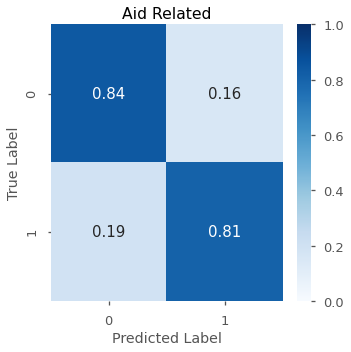

In [93]:
# Confusion matrix on test data.
dis.plot_confusion_matrix(dw.Y_test(), 
                          THE_y_pred_binary,
                          'Aid Related')

In [94]:
# Split messages into [correctly-predicted, incorrectly-predicted].
# Get indexes of each category.
correct_idx = []
incorrect_idx = []
for n, (t, p) in enumerate(zip(dw.Y_test(), THE_y_pred_binary)):
    if t == p:
        correct_idx.append(n)
        continue
    incorrect_idx.append(n)

# Get messages from indexes.
correct_messages = dw.X_test()[correct_idx]
incorrect_messages = dw.X_test()[incorrect_idx]

len(correct_messages), len(incorrect_messages)

(2087, 437)

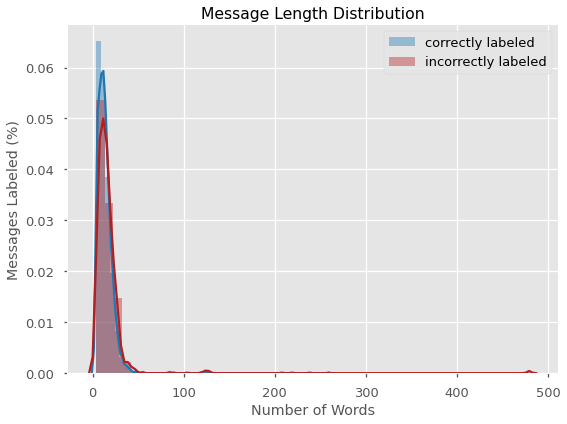

In [95]:
# Message length.
correct_messages_len = [len(x) for x in correct_messages]
incorrect_messages_len = [len(x) for x in incorrect_messages]

fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(correct_messages_len, color=COLORS['blue'], 
             label='correctly labeled', ax=ax)
sns.distplot(incorrect_messages_len, color=COLORS['red'], 
             label='incorrectly labeled', ax=ax)
ax.legend()
ax.set(title='Message Length Distribution', 
       xlabel='Number of Words', 
       ylabel='Messages Labeled (%)')
fig.tight_layout()

*Not much separation in the populations based on message length.*

In [96]:
# Common words.
word_freq_test = {}
for lst in dw.X_test():
    for word in lst:
        word_freq_test[word] = word_freq_test.get(word, 0) + 1
        
top_10_test_freq = sorted(list(word_freq_test.items()), 
                          key=lambda x: -x[1])[:10]
top_10_test_freq

[('food', 303),
 ('water', 297),
 ('people', 297),
 ('need', 268),
 ('help', 250),
 ('please', 193),
 ('earthquake', 176),
 ('u', 170),
 ('area', 154),
 ('like', 144)]

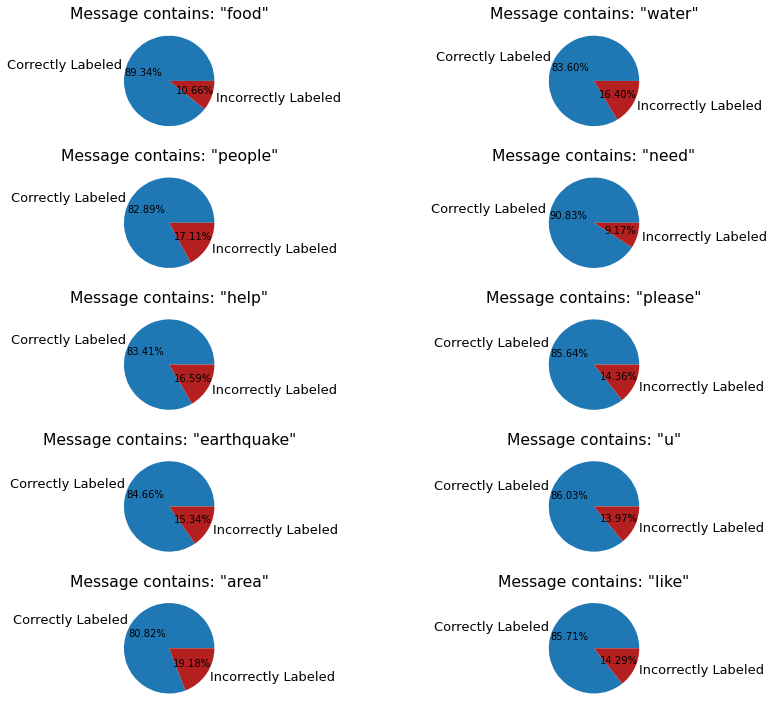

In [97]:
fig, ax_lst = plt.subplots(nrows=5, ncols=2, figsize=(12,10))
for (word, _), ax in zip(top_10_test_freq, ax_lst.flatten()):
    correct_messages_has_word = sum([int(word in m) 
                                     for m in correct_messages])
    incorrect_messages_has_word = sum([int(word in m) 
                                       for m in incorrect_messages])
    num_messages_with_word = correct_messages_has_word + \
                             incorrect_messages_has_word
    ax.pie([correct_messages_has_word, incorrect_messages_has_word],
           labels=['Correctly Labeled', 'Incorrectly Labeled'],
           colors=[COLORS['blue'], COLORS['red']],
           autopct=lambda p: f'{p:.2f}%')
    ax.set(title=f'Message contains: "{word}"')
fig.tight_layout()

## Prediction Time - Simulation

For a human, let's say it takes 1.5 seconds per word to read and ingest message and an additional 2 seconds to label it.

How long would it take to label the test set by hand compared to predicting with the model?

In [98]:
human_simulated_time = lambda word_count: (word_count * 1.5) + 2

time_for_human = []
time_for_model = []
message_count = list(range(1, len(dw.X_test())+1))

# Make an inference on each message individually.
# The model's time includes the data-processing step.
for message in dw.X_test():
    # Human time - simulated.
    human_time = human_simulated_time(len(message))
    
    # Model time - literal.
    start = datetime.datetime.now()
    inference(message, tokenizer, THE_MODEL, verbose=False)
    end = datetime.datetime.now()
    elapsed = end - start
    model_time = elapsed.microseconds / 1e+6 # in seconds
    
    time_for_human.append(human_time)
    time_for_model.append(model_time)

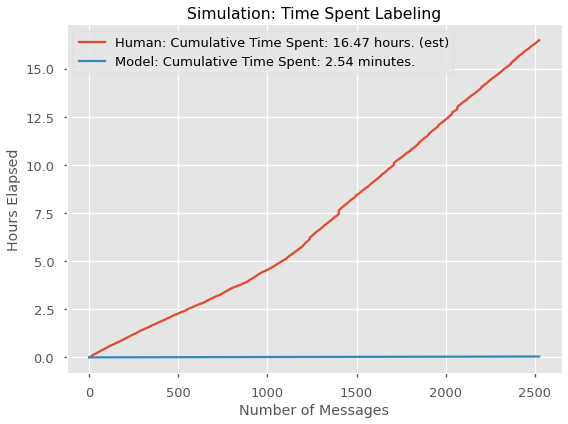

In [99]:
cumulative_human_hours = np.cumsum(np.array(time_for_human) / 60 / 60)
cumulative_model_hours = np.cumsum(np.array(time_for_model) / 60 / 60)

hum_final_hrs = round(cumulative_human_hours[-1], 2)
mod_final_mints = round(cumulative_model_hours[-1] * 60, 2)

# Plot times.
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(message_count, 
        cumulative_human_hours, 
        label=f'Human: Cumulative Time Spent: {hum_final_hrs} hours. (est)')
ax.plot(message_count, 
        cumulative_model_hours, 
        label=f'Model: Cumulative Time Spent: {mod_final_mints} minutes.')
ax.set(title='Simulation: Time Spent Labeling',
       xlabel='Number of Messages',
       ylabel='Hours Elapsed')
ax.legend()
fig.tight_layout()

# Conclusion
## Recommendations: Best Model

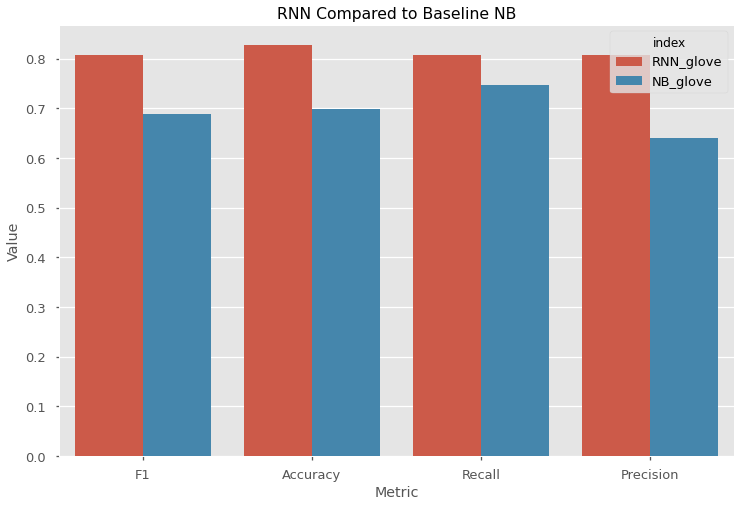

In [100]:
# Plot model comparison.
fig, ax = plt.subplots()
sns.barplot(x='variable', 
            y='value', 
            hue='index',
            data=pd.melt(RESULTS.loc[['RNN_glove', 'NB_glove']].reset_index(), 
                         id_vars='index'),
            ax=ax)
ax.set(title='RNN Compared to Baseline NB', 
       xlabel='Metric',
       ylabel='Value')
fig.tight_layout()

### For use:
- If the priority is overall accuracy, confidence in positive predictions, and balance (F1):
  - The **Recurrent Neural Network** with GloVe embeddings scored significantly best: 81% of aid-related predictions were correct, and 83% of its overall predictions were correct.

- If the priority is to find the most aid-related messages (at the expense of mislabeling many messages as aid-related):
  - **Logistic Regression** with the homemade Vectorizer scored the best: finding 86% of all aid-related messages.

Additionally, if used in the field would, this model would save hours of man-power. 
 - **With approximately 2500 messages, the model would save approximately 15 hours of time that would have been spent with a human-labeler.**

***

### For construction:

The Recurrent Neural Network (LSTM) had the best aptitude for the problem. Its ability to interpret the word sequences proved to be very valuable.

This type of model - with either a more complex topography and/or a much longer training time - would be recommended.

There are some keys to the architecture that can be noted here:

- Having **several LSTM layers** stacked in a row improved model performance drastically compared to only having a single layer.
- **TimeDistributed layers followed with a Flatten layer** performed better than when the LSTM layers did not return sequential information.
- The **three Dense layers** worked in the balance between too complex and poor performance.
   
## For the future
- Include the multitude of other labels to further identify the messages.
- Experiment with more RNN architectures to try to get better results.